## 2D implicit (backward Euler method)
<img src="img/euler imp.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import clear_output
import time

plt.rcParams.update({'font.size': 14})
from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi

from utilities import GS,smoothing, restriction, residual,prolongation


## Helper function for applying BCs and initialize source term, S and initial phi, phi

In [2]:
def applyBC(phi, Nx, Ny, S, L, H, convert_to_K=False):
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        y = j * dy
        phiR = 1000 * (0.25 * np.sinh(0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 1000 * (0.25 * np.sinh(-0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

            ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 1000 * (0.25 * np.sinh(-0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 1000 * (0.25 * np.sinh(0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S


def prepare_phi_and_S(Nx, Ny, L, H, convert_to_K=False):
    # Generate RHS source terms and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx, Ny))
    phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 1000 * (
                    2 * np.sinh(x - 0.5) + 4 * (x - 0.5) * np.cosh(x - 0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
            + 1000 * (2 * np.sinh(y - 0.5) + 4 * (y - 0.5) * np.cosh(y - 0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

            S[i, j] = -source

    phi, S = applyBC(phi, Nx, Ny, S, L, H)

    return phi, S
    

# Gauss-Siedel method

In [3]:
start = time.time()
Nx = 41
Ny = 41
L = 1  # length
H = 1  # length

dx = L / (Nx - 1)  # Grid size
dy = L / (Ny - 1)  # Grid size

t = 0
alpha = 1
tol = 1e-6

# maximum time step according to stability analysis
dtmax = (0.5 / alpha) / (1 / dx ** 2 + 1 / dy ** 2)

# an implicit method can use larger time step
dt = 5 * dtmax

# diagonal terms for transient problem
aE = -alpha / dx ** 2
aW = -alpha / dx ** 2
aN = -alpha / dy ** 2
aS = -alpha / dy ** 2
a0 = (1 / dt + 2 * alpha / dx ** 2 + 2 * alpha / dy ** 2)

phi1, S = prepare_phi_and_S(Nx, Ny, L, H)


# A helper function to define new RHS terms. See image in very first line of this notebook
def newRHS(S,phi1,dt,alpha,dx,dy,Nx,Ny):
    RHS = np.zeros(S.shape)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            RHS[i,j] = S[i,j] + phi1[i,j]/dt
    return RHS

# Outer loop: time advancement
# Inner loop: iterative solvers for solving each time step

total_n = 1000


with tqdm_notebook(range(total_n)) as t:
    for n in t:

        # if n%10==0:
        #     clear_output(True)
        # Progress bar update 
        description = 'Time: ' + str(n*dt)
        t.set_description(desc=description[:14])
        RHS = newRHS(S,phi1,dt,alpha,dx,dy,Nx,Ny)
        for _ in (range(10000)):

            phi1 = GS(Nx, Ny, phi1, RHS, aE, aW, aN, aS, a0)

            # Calculate residual
            R2, Rsum, R = residual(Nx, Ny, phi1, RHS, aE, aW, aN, aS, a0)

            if _%100==0:
                print(f'Residual: {R2:.7f} @ {n}/{total_n}',end="\r",flush=True)
                


            if R2 < tol:
                
                break
        
        # if converged in iterative solver first loop, then it is already having the solution same as steady-state. Can stop
        if _ == 0 and R2<tol:
            break
        

/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_6165/530453172.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(range(total_n)) as t:


  0%|          | 0/1000 [00:00<?, ?it/s]

## Steady-state solution

In [4]:

start = time.time()
Nx = 41
Ny = 41
L = 1   # length
H = 1   # length


dx = L/(Nx-1)    # Grid size
dy = L/(Ny-1)    # Grid size

tol = 1e-6
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)

phi, S = prepare_phi_and_S(Nx, Ny, L,H)
S = -S

total_n = 10000
for _ in tqdm_notebook(range(total_n)):
    description = "Iteration: "+str(_)
    t.set_description(desc=description)
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):

            # Gauss-Siedel Update
            phi[i,j] = (S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1]) / a0

    # Calculate residual
    R2 = 0
    R = np.zeros((Nx,Ny))

    for i in range(1,Nx-1):    
        for j in range(1,Ny-1):
            R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
            R2 = R2+R[i,j]**2

    R2 = np.sqrt(R2)
    if _%100==0:
        print(f'Residual: {R2:.7f} @ {n}/{total_n}',end="\r",flush=True)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break


/var/folders/q9/8vn_nzj55b55_336zczh1y2c0000gp/T/ipykernel_6165/3053735623.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(total_n)):


  0%|          | 0/10000 [00:00<?, ?it/s]

Converged! Residual:  9.986470548375556e-07 Time elapsed:  17.59646725654602


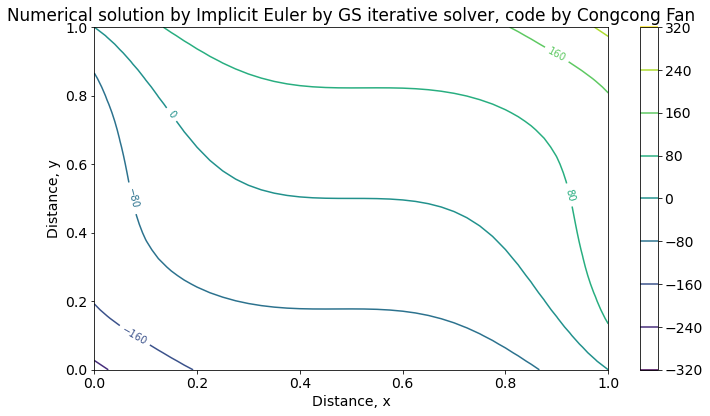

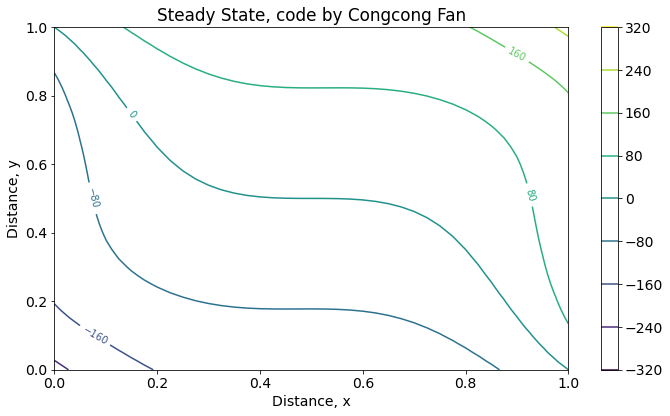

In [5]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = 1000* ( (x[i]-0.5)**2*np.sinh(x[i]-0.5) + (y[j]-0.5)**2 * np.sinh(y[j]-0.5))

plot_phi(phi1, phi, Nx,Ny, 'Implicit Euler by GS', convert=False,method2_name='Steady State')
